Detected 65 horizontal lines and 60 vertical lines.
Detected Rows: 8, Columns: 8


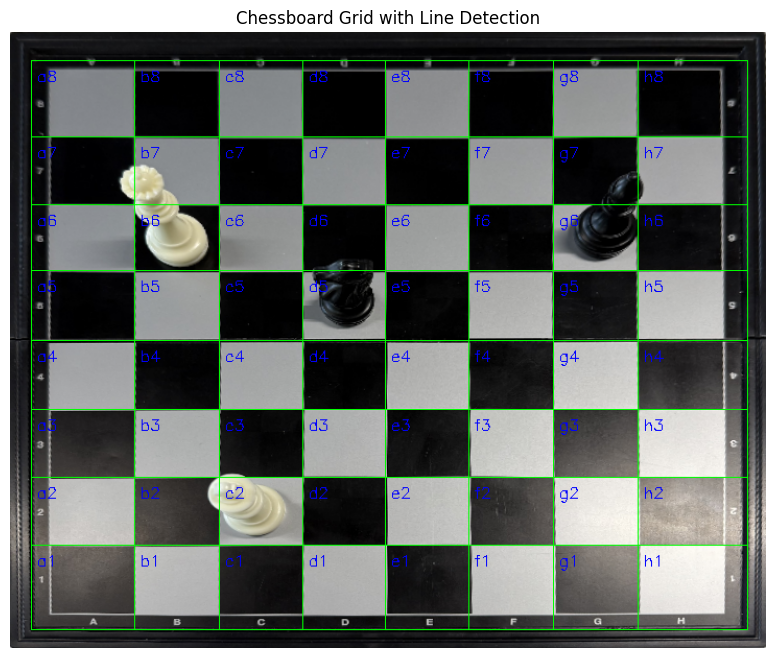


Square positions saved to 'chessboard_squares_final.json'.
Error occurred: invalid literal for int() with base 10: ''


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json


# --- Helper Functions ---

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def find_intersections(horizontal_lines, vertical_lines):
    intersections = []
    for h in horizontal_lines:
        for v in vertical_lines:
            x1_h, y1_h, x2_h, y2_h = h[0]
            x1_v, y1_v, x2_v, y2_v = v[0]

            A = np.array([
                [x2_h - x1_h, x1_v - x2_v],
                [y2_h - y1_h, y1_v - y2_v]
            ])
            b = np.array([x1_v - x1_h, y1_v - y1_h])

            if np.linalg.det(A) != 0:
                t, s = np.linalg.solve(A, b)
                px = int(x1_h + t * (x2_h - x1_h))
                py = int(y1_h + t * (y2_h - y1_h))
                intersections.append((px, py))
    return intersections

# --- Load Image ---

img_path = 'chessboard1.jpeg'  # Update your path
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Image at {img_path} not found!")

# Resize if too large
max_dim = 1000
if max(img.shape) > max_dim:
    scale = max_dim / max(img.shape)
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

original_img = img.copy()

# --- Preprocessing ---

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# --- Find Board Contour ---

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

board_contour = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        board_contour = approx
        break

if board_contour is None:
    raise Exception("Could not find 4-corner board contour!")

# --- Warp Board ---

warped = four_point_transform(original_img, board_contour.reshape(4, 2))

# --- Line Detection ---

gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
edges_warped = cv2.Canny(gray_warped, 50, 150)

lines = cv2.HoughLinesP(edges_warped, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=10)

horizontal = []
vertical = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    if abs(y2 - y1) < abs(x2 - x1):  # More horizontal
        horizontal.append(line)
    else:
        vertical.append(line)

print(f"Detected {len(horizontal)} horizontal lines and {len(vertical)} vertical lines.")

# --- Find Intersections ---

intersections = find_intersections(horizontal, vertical)

if len(intersections) < 30:
    raise Exception("Not enough intersections detected!")

# --- Cluster Intersections ---

# Cluster points
def cluster_points(points, threshold=20):
    points = sorted(points)
    clustered = []
    group = [points[0]]
    for p in points[1:]:
        if abs(p - group[-1]) < threshold:
            group.append(p)
        else:
            clustered.append(int(np.mean(group)))
            group = [p]
    clustered.append(int(np.mean(group)))
    return clustered

xs = [p[0] for p in intersections]
ys = [p[1] for p in intersections]

clustered_xs = cluster_points(xs, threshold=30)
clustered_ys = cluster_points(ys, threshold=30)

cols = len(clustered_xs) - 1
rows = len(clustered_ys) - 1

print(f"Detected Rows: {rows}, Columns: {cols}")

# --- Draw Grid ---

square_positions = {}
square_grid_img = warped.copy()

for row in range(rows):
    for col in range(cols):
        x1 = clustered_xs[col]
        y1 = clustered_ys[row]
        x2 = clustered_xs[col + 1]
        y2 = clustered_ys[row + 1]

        cv2.rectangle(square_grid_img, (x1, y1), (x2, y2), (0, 255, 0), 1)

        file_letter = chr(97 + col)  # a, b, ..., h
        rank_number = rows - row     # 8 down to 1
        square_name = f"{file_letter}{rank_number}"

        square_positions[square_name] = {
            'center': (int((x1+x2)/2), int((y1+y2)/2)),
            'corners': [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        }

        cv2.putText(square_grid_img, square_name, (x1+5, y1+20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# --- Show Final Grid ---

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(square_grid_img, cv2.COLOR_BGR2RGB))
plt.title('Chessboard Grid with Line Detection')
plt.axis('off')
plt.show()

# Save square positions
with open('chessboard_squares_final.json', 'w') as f:
    json.dump({k: {'center': v['center'], 'corners': v['corners']} for k, v in square_positions.items()}, f)

print("\nSquare positions saved to 'chessboard_squares_final.json'.")




#--- Close any open figures ---
plt.close('all')

# --- Define function to find square ---
def find_square(x, y, square_positions):
    for square_name, data in square_positions.items():
        (x1, y1) = data['corners'][0]
        (x2, y2) = data['corners'][2]
        if x1 <= x <= x2 and y1 <= y <= y2:
            return square_name
    return None

# --- Ask for x, y inputs ---
try:
    x_input = int(input("Enter x coordinate: "))
    y_input = int(input("Enter y coordinate: "))

    found_square = find_square(x_input, y_input, square_positions)

    if found_square:
        print(f"The coordinate ({x_input}, {y_input}) is in square {found_square}")
    else:
        print("No square found for the given coordinates.")

except Exception as e:
    print(f"Error occurred: {e}")


